<a href="https://colab.research.google.com/github/dispectra/truck-trailer-kinematic-sim/blob/main/Truck_Trailer_Kinematics_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Truck Trailer Kinematics Simulation**
<br/>

---
This notebook is created by Dimas Apeco Putra (github.com/dispectra). Major part of this notebook is an adaptation of MATLAB codes of Bani Asrofudin's thesis at Instrumentation and Control Research Group at Institut Teknologi Bandung. Original purpose of this notebook is to support research written in the following paper.
- Asrofudin, B., Widyotriatmo, A., Siregar, P., **Putra, D.A.**. 2021. *Sigmoid Function Optimization for Path Following Control with Obstacle Avoidance of an Autonomous Truck-Trailer.* The 7th International
Conference on Instrumentation, Control and Automation (ICA) 2021. Bandung, Indonesia.

## Utilities Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Path Planning

### Helper functions

In [2]:
def distance(first_pose, second_pose): # euclidean
  return np.sqrt((first_pose[0]-second_pose[0])**2 + (first_pose[1]-second_pose[1])**2)

def generateLineWP(start_pose, resolution, include_start, include_end, end_pose=None, length=None):
  if length != None:
    end_pose = [start_pose[0]+length*np.cos(start_pose[2]), start_pose[1]+length*np.sin(start_pose[2]), start_pose[2]]
  wp_buf = np.array([start_pose])
  iteration = int(distance(start_pose, end_pose)/resolution)
  if (distance(start_pose, end_pose)/resolution) % 1 == 0:
    iteration = iteration-1
  delta_x = (end_pose[0]-start_pose[0])/iteration
  delta_y = (end_pose[1]-start_pose[1])/iteration
  for i in range(iteration):
    x_i = wp_buf[i,0]+delta_x
    y_i = wp_buf[i,1]+delta_y
    theta_i = wp_buf[i,2]
    wp_buf = np.vstack((wp_buf, [x_i, y_i, theta_i]))
  if include_end:
    wp_buf = np.vstack((wp_buf, end_pose))
  if not include_start:
    wp_buf = wp_buf[1:]
  return wp_buf

def generateCircularWP(start_pose, radius, arc_angle, resolution, include_start, include_end):
  # arc_angle: (+) for counter clockwise turn, (-) for clockwise turn. cannot be zero.

  buf = np.array([[0,0,0]])
  angle_step = 2 * np.arcsin(0.5*resolution/radius) * np.sign(arc_angle)
  iteration = int(arc_angle/angle_step)
  if (arc_angle/angle_step) % 1 == 0:
    iteration = iteration-1
  angle_next = angle_step
  for i in range(iteration):
    x_next = buf[-1,0] + np.cos(angle_next) * resolution
    y_next = buf[-1,1] + np.sin(angle_next) * resolution
    theta_next = buf[-1,2] + angle_step
    angle_next = angle_next + angle_step
    buf = np.vstack((buf, [x_next, y_next, theta_next]))  
  # last point
  # x_center = 0
  # y_center = radius * np.sign(arc_angle)
  # x_last = x_center + np.sin(arc_angle) * radius
  # y_last = y_center + radius - np.cos(arc_angle) * radius
  # theta_last = start_pose[2] + arc_angle
  # buf = np.vstack((buf, [x_last, y_last, theta_last]))
  x_next = buf[-1,0] + np.cos(arc_angle) * resolution
  y_next = buf[-1,1] + np.sin(arc_angle) * resolution
  theta_next = 0 + arc_angle
  buf = np.vstack((buf, [x_next, y_next, theta_next]))
  buf[:,2] = wrapAngle(buf[:,2])

  if not include_start:
    buf = buf[1:]
  if not include_end:
    buf = buf[:-1]

  buf = transformFrameWP(buf, start_pose)

  return buf

def wrapAngle(angle):
  return (((angle + np.pi) % (2*np.pi)) - np.pi)

def transformFrameWP(wp_buf, start_pose):
  #transform to start_pose frame
  ##rotation
  wp_buf_rot = np.copy(wp_buf)
  wp_buf_rot[:,0] = np.cos(start_pose[2])*wp_buf[:,0] - np.sin(start_pose[2])*wp_buf[:,1]
  wp_buf_rot[:,1] = np.sin(start_pose[2])*wp_buf[:,0] + np.cos(start_pose[2])*wp_buf[:,1]
  wp_buf_rot[:,2] = wp_buf[:,2] + start_pose[2]
  ##translation
  wp_buf[:,0] = wp_buf_rot[:,0] + start_pose[0]
  wp_buf[:,1] = wp_buf_rot[:,1] + start_pose[1]
  wp_buf[:,2] = wrapAngle(wp_buf_rot[:,2])
  
  return wp_buf

# test = generateCircularWP([5,5,np.pi/2], 0.5, np.pi/2, 0.01, include_start=False, include_end=True)
# test = generateSigmoidWP(start_pose=[0,0,0],
#                                            height=5,
#                                            c1=0.55, c2=15-2.0247,
#                                            resolution=0.01,
#                                            include_start=False,
#                                            include_end=True)
# plt.subplot(2,1,1)
# plt.plot(test[:,0], test[:,1])
# plt.axis('square')
# plt.subplot(2,1,2)
# plt.plot(test[1:,2])

### Optimized Sigmoid Path Planning

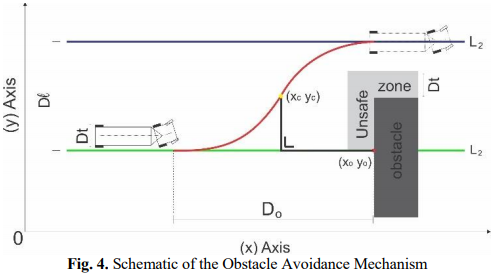

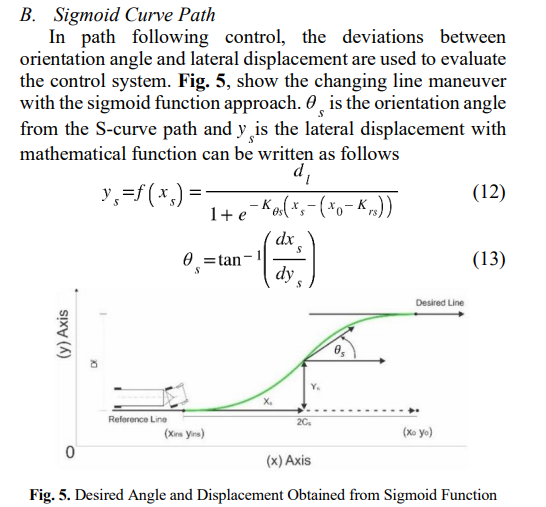

In [ ]:
def generateSigmoidWP(start_pose, height, c1, c2, resolution, include_start, include_end):
  wp_buf = np.array([[0,0,0]])
  iteration = int(2*c2/resolution) 
  if (2*c2/resolution) % 1 == 0:
    iteration = iteration-1
  delta_x = resolution
  for i in range(iteration):
    x_i = wp_buf[i,0]+delta_x
    y_i = height/(1+np.exp(-c1*(x_i-c2)))
    theta_i = np.arctan2(y_i-wp_buf[i,1], x_i-wp_buf[i,0])
    wp_buf = np.vstack((wp_buf, [x_i, y_i, theta_i]))

  x_i = 2*c2
  y_i = height
  theta_i = 0
  wp_buf = np.vstack((wp_buf, [x_i, y_i, theta_i]))

  if len(wp_buf) > 3:
    wp_buf[0,2] = wp_buf[2,2]
    wp_buf[1,2] = wp_buf[2,2]
  if not include_start:
    wp_buf = wp_buf[1:]
  if not include_end:
    wp_buf = wp_buf[:-1]

  # #transform to start_pose frame
  # ##rotation
  # wp_buf_rot = np.copy(wp_buf)
  # wp_buf_rot[:,0] = np.cos(start_pose[2])*wp_buf[:,0] - np.sin(start_pose[2])*wp_buf[:,1]
  # wp_buf_rot[:,1] = np.sin(start_pose[2])*wp_buf[:,0] + np.cos(start_pose[2])*wp_buf[:,1]
  # wp_buf_rot[:,2] = wp_buf[:,2] + start_pose[2]
  # ##translation
  # wp_buf[:,0] = wp_buf_rot[:,0] + start_pose[0]
  # wp_buf[:,1] = wp_buf_rot[:,1] + start_pose[1]
  # wp_buf[:,2] = wp_buf_rot[:,2]
  wp_buf = transformFrameWP(wp_buf, start_pose)

  return wp_buf

### Create Waypoints

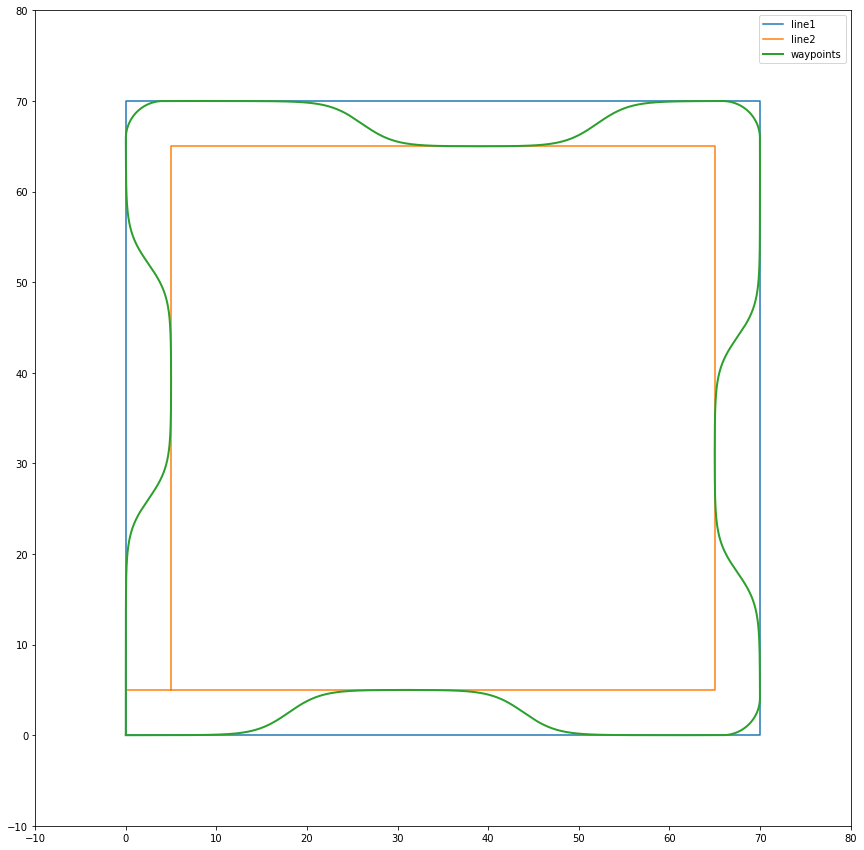

In [3]:
# k_sigmoid_1 = 1
# k_sigmoid_2 = 2.0101
k_sigmoid_1 = 0.55
k_sigmoid_2 = 2.0247 # m
line_distance = 5 # m
sensor_detect_distance = 15 # m
waypoints_resolution = 0.01 # m
segment_length = 70 #m
straight_path_length = 5 #m
# turn_radius = 0.1 #m
## EXP: minimal turning radius to avoid overshoot out of the outer line square
d_steer_lim = np.pi/5 #rad
l_head = 1 #m
l_trailer = 1 #m
turn_radius = (l_trailer+2*l_head)/np.tan(d_steer_lim)

# segment 1 (bottom)
waypoints = generateLineWP(start_pose=[0,0,0], 
                             length=straight_path_length,
                             resolution=waypoints_resolution, 
                             include_start=True, 
                             include_end=True)
waypoints = np.vstack((waypoints,
                       generateSigmoidWP(start_pose=waypoints[-1],
                                           height=line_distance,
                                           c1=k_sigmoid_1, c2=sensor_detect_distance-k_sigmoid_2,
                                           resolution=waypoints_resolution,
                                           include_start=False,
                                           include_end=True)))
waypoints = np.vstack((waypoints,
                       generateSigmoidWP(start_pose=waypoints[-1],
                                           height=-line_distance,
                                           c1=k_sigmoid_1, c2=sensor_detect_distance-k_sigmoid_2,
                                           resolution=waypoints_resolution,
                                           include_start=False,
                                           include_end=True)))
waypoints = np.vstack((waypoints,
                       generateLineWP(start_pose=waypoints[-1],
                                        resolution=waypoints_resolution,
                                        include_start=False, include_end=True,
                                        end_pose=[segment_length-turn_radius,0,0])))
waypoints = np.vstack((waypoints,
                       generateCircularWP(start_pose=waypoints[-1],
                                        radius=turn_radius,
                                        arc_angle=np.pi/2,
                                        resolution=waypoints_resolution,
                                        include_start=False, include_end=True)))
# segment 2 (right)
waypoints = np.vstack((waypoints,
                       generateLineWP(start_pose=waypoints[-1], #[segment_length, 0, np.pi/2]
                                        resolution=waypoints_resolution,
                                        include_start=False,
                                        include_end=True,
                                        length=straight_path_length-turn_radius)))
waypoints = np.vstack((waypoints,
                       generateSigmoidWP(start_pose=waypoints[-1],
                                           height=line_distance,
                                           c1=k_sigmoid_1, c2=sensor_detect_distance-k_sigmoid_2,
                                           resolution=waypoints_resolution,
                                           include_start=False,
                                           include_end=True)))
waypoints = np.vstack((waypoints,
                       generateSigmoidWP(start_pose=waypoints[-1],
                                           height=-line_distance,
                                           c1=k_sigmoid_1, c2=sensor_detect_distance-k_sigmoid_2,
                                           resolution=waypoints_resolution,
                                           include_start=False,
                                           include_end=True)))
waypoints = np.vstack((waypoints,
                       generateLineWP(start_pose=waypoints[-1],
                                        resolution=waypoints_resolution,
                                        include_start=False,
                                        include_end=True,
                                        end_pose=[segment_length,segment_length-turn_radius,np.pi/2])))
waypoints = np.vstack((waypoints,
                       generateCircularWP(start_pose=waypoints[-1],
                                        radius=turn_radius,
                                        arc_angle=np.pi/2,
                                        resolution=waypoints_resolution,
                                        include_start=False, include_end=True)))
# segment 3 (top)
waypoints = np.vstack((waypoints,
                       generateLineWP(start_pose=waypoints[-1], #[segment_length, segment_length, np.pi]
                                        resolution=waypoints_resolution,
                                        include_start=False,
                                        include_end=True,
                                        length=straight_path_length-turn_radius)))
waypoints = np.vstack((waypoints,
                       generateSigmoidWP(start_pose=waypoints[-1],
                                           height=line_distance,
                                           c1=k_sigmoid_1, c2=sensor_detect_distance-k_sigmoid_2,
                                           resolution=waypoints_resolution,
                                           include_start=False,
                                           include_end=True)))
waypoints = np.vstack((waypoints,
                       generateSigmoidWP(start_pose=waypoints[-1],
                                           height=-line_distance,
                                           c1=k_sigmoid_1, c2=sensor_detect_distance-k_sigmoid_2,
                                           resolution=waypoints_resolution,
                                           include_start=False,
                                           include_end=True)))
waypoints = np.vstack((waypoints,
                       generateLineWP(start_pose=waypoints[-1],
                                        resolution=waypoints_resolution,
                                        include_start=False,
                                        include_end=True,
                                        end_pose=[0+turn_radius,segment_length,np.pi])))
waypoints = np.vstack((waypoints,
                       generateCircularWP(start_pose=waypoints[-1],
                                        radius=turn_radius,
                                        arc_angle=np.pi/2,
                                        resolution=waypoints_resolution,
                                        include_start=False, include_end=True)))
# segment 4 (left)
waypoints = np.vstack((waypoints,
                       generateLineWP(start_pose=waypoints[-1], #[0, segment_length, -np.pi/2]
                                        resolution=waypoints_resolution,
                                        include_start=False,
                                        include_end=True,
                                        length=straight_path_length-turn_radius)))
waypoints = np.vstack((waypoints,
                       generateSigmoidWP(start_pose=waypoints[-1],
                                           height=line_distance,
                                           c1=k_sigmoid_1, c2=sensor_detect_distance-k_sigmoid_2,
                                           resolution=waypoints_resolution,
                                           include_start=False,
                                           include_end=True)))
waypoints = np.vstack((waypoints,
                       generateSigmoidWP(start_pose=waypoints[-1],
                                           height=-line_distance,
                                           c1=k_sigmoid_1, c2=sensor_detect_distance-k_sigmoid_2,
                                           resolution=waypoints_resolution,
                                           include_start=False,
                                           include_end=True)))
waypoints = np.vstack((waypoints,
                       generateLineWP(start_pose=waypoints[-1],
                                        resolution=waypoints_resolution,
                                        include_start=False,
                                        include_end=True,
                                        end_pose=[0,0.1,-np.pi/2])))
                                

line1 = np.array([[0,0],
                  [segment_length,0],
                  [segment_length,segment_length],
                  [0,segment_length],
                  [0,0]])
line2 = np.array([[0,line_distance],
                  [segment_length-line_distance, line_distance],
                  [segment_length-line_distance, segment_length-line_distance],
                  [line_distance, segment_length-line_distance],
                  [line_distance, line_distance]])

plt.figure(figsize=(15,15))
plt.plot(line1[:,0], line1[:,1], label="line1")
plt.plot(line2[:,0], line2[:,1], label="line2")
# plt.scatter(waypoints[:,0], waypoints[:,1], s=1, label="waypoints")
plt.plot(waypoints[:,0], waypoints[:,1], lw=2, label="waypoints")
plt.axis('square')
plt.xlim([-10,segment_length+10])
plt.ylim([-10,segment_length+10])
plt.legend()

3.141592653589793 -3.141592653589793 3.141592653589793


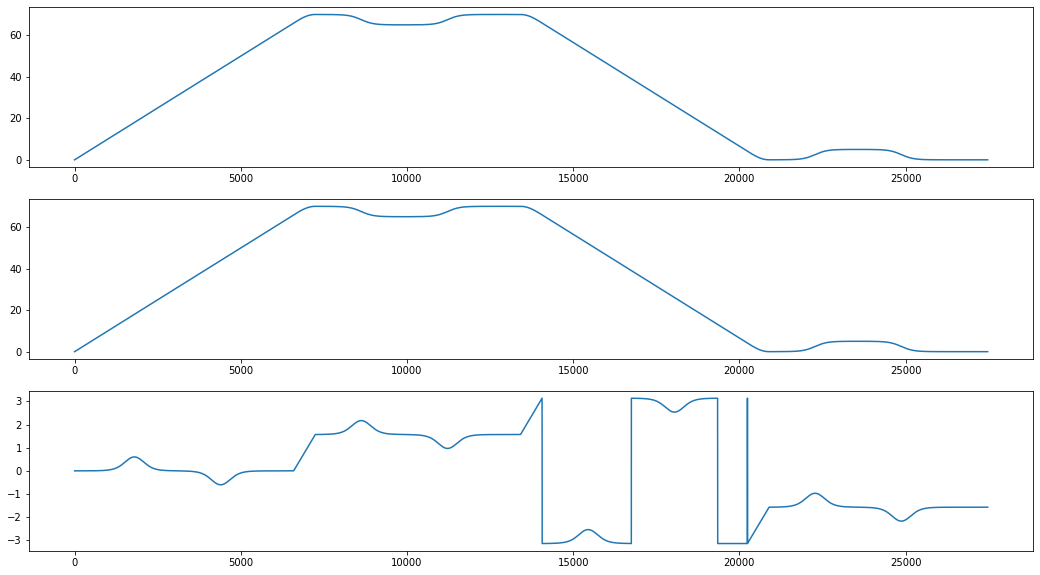

In [4]:
# Check created waypoints
plt.figure(figsize=(18,10))
# plt.subplot(1,2,1)
# plt.plot(line1[:,0], line1[:,1], label="line1")
# plt.plot(line2[:,0], line2[:,1], label="line2")
# # plt.scatter(waypoints[:,0], waypoints[:,1], s=1, label="waypoints")
# plt.plot(waypoints[:,0], waypoints[:,1], lw=2, label="waypoints")
# plt.axis('square')
# plt.xlim([-10,segment_length+10])
# plt.ylim([-10,segment_length+10])
# plt.legend()
# plt.subplot(1,2,2)
plt.subplot(3,1,1)
plt.plot(waypoints[:,0])
plt.subplot(3,1,2)
plt.plot(waypoints[:,0])
plt.subplot(3,1,3)
plt.plot(waypoints[:,2])
print(np.pi, np.min(waypoints[:,2]), np.max(waypoints[:,2]))

## Truck Trailer Object Definition

### Truck trailer geometry

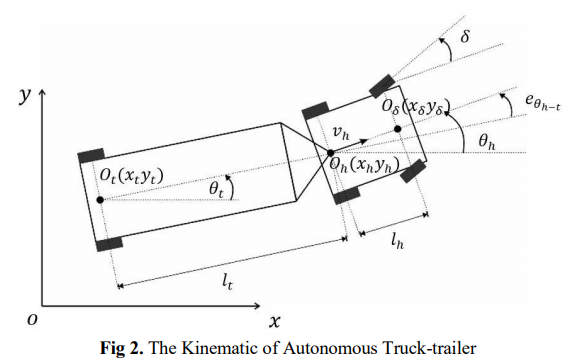

In [5]:
class TruckTrailer():
  """
  This class describe the truck trailer object used in the simulation.
  """

  def __init__(self, waypoints, l_head=1, l_trailer=1):

    # Truck trailer geometry
    self.l_head = l_head # Length of head
    self.l_trailer = l_trailer # Length of trailer
    # self.l_h2t = 0.5 * (self.l_head + self.l_trailer) + 0.25 # Length from the center point of trailer to the center point of head
    self.l_h2t = self.l_head + self.l_trailer

    # Simulation initial value
    self.x_trailer = 0
    self.y_trailer = -0.5
    self.theta_trailer = 0
    self.theta_head = 0
    self.theta_h2t = self.theta_head - self.theta_trailer
    self.x_head = self.x_trailer + self.l_h2t * np.cos(self.theta_h2t)
    self.y_head = self.y_trailer + self.l_h2t * np.sin(self.theta_h2t)
    self.psi = 0
    self.idx_closest = 0
    self.waypoints = waypoints

    # Simulation parameter
    self.v_head_max = 0.6
    self.v_head = self.v_head_max
    self.k1_h = 1 # Coefficient of head distance error
    self.k1_theta = 1 # Coefficient of head angle error
    self.k2_t = 1 # Coefficient of trailer distance error
    self.k2_theta = 1 # Coefficient of trailer angle error

### Comparator: Navigation Variable

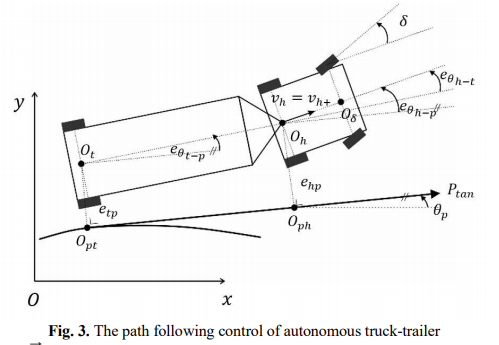

In [6]:
class TruckTrailer(TruckTrailer):
  def evaluateComparator(self):
    """
    This function resembles "comparator block" in a generic control system block diagram.
    This function finds lateral and orientation error of the truck with respect to the waypoints.
    The waypoint used as reference is the closest point to the current truck position.
    """

    # Find closest point index
    ## Set reference of distance to waypoints
    x_ref, y_ref = self.x_trailer, self.y_trailer
    # x_ref, y_ref = self.x_head, self.y_head
    ## Find minimal Euclidean distance of waypoints to reference
    self.idx_closest = np.argmin(np.sum(np.square(self.waypoints[:, :2] - np.array([x_ref, y_ref])), axis=-1))


    # Find lateral error and theta error
    if self.idx_closest == 0:
        self.idx_closest = 1
    x2 = self.waypoints[self.idx_closest, 0]
    y2 = self.waypoints[self.idx_closest, 1]
    x1 = self.waypoints[self.idx_closest - 1, 0]
    y1 = self.waypoints[self.idx_closest - 1, 1]
    dy = y2 - y1
    dx = x2 - x1
    c = dx*y1 - dy*x1

    self.r_trailer_e = -1 * (dy*x_ref + c - dx*y_ref) \
                       / (np.sqrt(dx**2 + dy**2) + 10**(-32))
    # theta_d = np.arctan2(self.waypoints[self.idx_closest, 1]-self.waypoints[self.idx_closest-1, 1],
    #                      self.waypoints[self.idx_closest, 0]-self.waypoints[self.idx_closest-1, 0]) 
    theta_d = waypoints[self.idx_closest, 2] 

    self.theta_trailer_e = self.theta_trailer - theta_d
    self.theta_trailer_e = wrapAngle(self.theta_trailer_e)

    self.theta_head_e = self.theta_head - theta_d
    # # EXP: Different waypoint reference for calculating head error
    x_ref, y_ref = self.x_head, self.y_head
    # idx_closest_head = np.argmin(np.sum(np.square(self.waypoints[:, :2] - np.array([x_ref, y_ref])), axis=-1))
    # if idx_closest_head == 0:
    #     idx_closest_head = 1
    # theta_d_head = np.arctan2(self.waypoints[idx_closest_head, 1]-self.waypoints[idx_closest_head-1, 1],
    #                           self.waypoints[idx_closest_head, 0]-self.waypoints[idx_closest_head-1, 0]) 
    # self.theta_head_e = self.theta_head - theta_d_head
    self.r_head_e = -1 * (dy*x_ref + c - dx*y_ref) \
                       / (np.sqrt(dx**2 + dy**2) + 10**(-32))

    self.theta_h2t_e = self.theta_head_e - self.theta_trailer_e

### Controller: Lyapunov-based Path Following Controller

Steering Angle Control
</br>
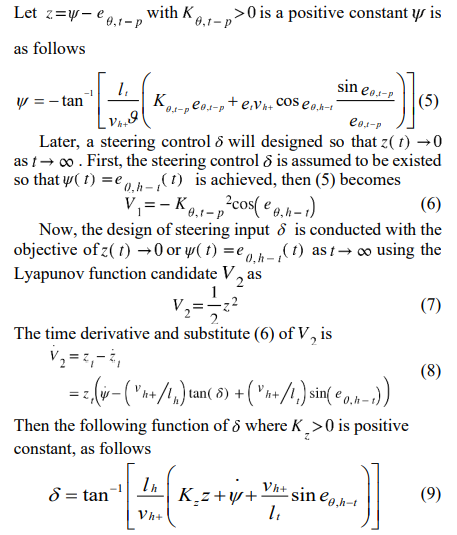

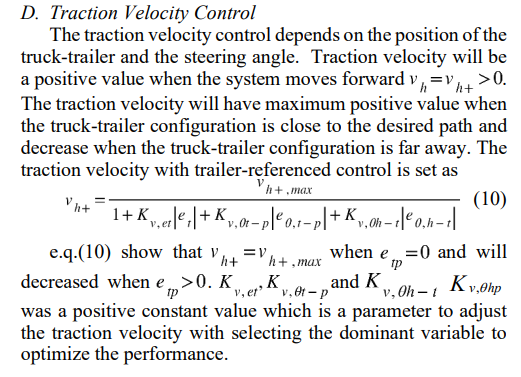

In [7]:
class TruckTrailer(TruckTrailer):
  def evaluateController(self):
    ### Control function of head velocity (v_head)
    v_head_next = self.v_head_max / (1 + self.k1_theta * abs(self.theta_trailer_e) + self.k1_h * abs(self.r_trailer_e))

    ### Control function of steering angle (d_steer)
    if abs(self.theta_h2t_e) >= np.pi / 5:
        self.theta_h2t_e = np.sign(self.theta_h2t_e) * np.pi / 5;
    psi_next = -np.arctan(self.l_trailer / (v_head_next) * \
                          (self.k1_theta * self.theta_trailer_e + v_head_next * self.r_trailer_e * np.cos(self.theta_h2t_e) * np.sinc(self.theta_trailer_e)))
    psi_dot = psi_next - self.psi
    z = psi_next - self.theta_h2t
    d_steer = np.arctan(self.l_head / (v_head_next) * \
                        (self.k1_theta * z + v_head_next / self.l_trailer * np.sin(self.theta_h2t_e) + psi_dot))
    self.psi = psi_next
    if abs(d_steer) >= np.pi / 5:
        d_steer = np.sign(d_steer) * np.pi / 5

    return d_steer, v_head_next

### Plant: Truck Trailer Motion Model

In [8]:
class TruckTrailer(TruckTrailer):
  def evaluatePlant(self, d_steer, v_head_next, dt):
    x_trailer_next = self.x_trailer + self.v_head * np.cos(self.theta_trailer) * np.cos(self.theta_h2t) * dt
    y_trailer_next = self.y_trailer + self.v_head * np.sin(self.theta_trailer) * np.cos(self.theta_h2t) * dt
    x_head_next = self.x_head + self.v_head * np.cos(self.theta_head) * dt
    y_head_next = self.y_head + self.v_head * np.sin(self.theta_head) * dt

    theta_trailer_next = self.theta_trailer + self.v_head / self.l_trailer * np.tan(self.theta_h2t) * dt
    theta_h2t_next = self.theta_h2t + self.v_head / self.l_trailer * (np.tan(d_steer - np.tan(self.theta_h2t))) * dt
    theta_head_next = theta_trailer_next + theta_h2t_next

    # To analyze
    # x_trailer_e_next = x_trailer_next - x_trailer_sim
    # y_trailer_e_next = y_trailer_next - y_trailer_sim
    # x_head_e_next = x_head_next - x_head_sim
    # y_head_e_next = y_head_next - y_head_sim
    # theta_trailer_e_next = theta_trailer_next - theta_trailer_sim
    # theta_head_e_next = theta_head_next - theta_head_sim

    self.x_trailer = x_trailer_next
    self.y_trailer = y_trailer_next
    self.x_head = x_head_next
    self.y_head = y_head_next
    self.theta_trailer = theta_trailer_next
    self.theta_head = theta_head_next

    self.theta_h2t = theta_h2t_next

    self.v_head = v_head_next

## Simulation

In [9]:
truck_a = TruckTrailer(waypoints,
                       l_head=l_head,
                       l_trailer=l_trailer)

log = {}
log["x_head"] = []
log["y_head"] = []
log["theta_head"] = []
log["x_trailer"] = []
log["y_trailer"] = []
log["theta_trailer"] = []
log["r_trailer_e"] = []
log["theta_trailer_e"] = []
# log["r_head_e"] = []
log["theta_head_e"] = []
log["v_head"] = []
log["d_steer"] = []
log["idx_closest"] = []

import time
terminate_simulation = False
wall_time_limit = 60 #seconds
finish_distance_limit = 0.1 #m
finish_wp_idx_limit = 200
time_start = time.time()

while terminate_simulation is False:
  truck_a.evaluateComparator()
  d_steer, v_head_next = truck_a.evaluateController()
  log["v_head"].append(truck_a.v_head)
  truck_a.evaluatePlant(d_steer, v_head_next, dt=0.05)
  
  # Logging simulation data
  log["x_head"].append(truck_a.x_head)
  log["y_head"].append(truck_a.y_head)
  log["theta_head"].append(truck_a.theta_head)
  log["x_trailer"].append(truck_a.x_trailer)
  log["y_trailer"].append(truck_a.y_trailer)
  log["theta_trailer"].append(truck_a.theta_trailer)
  log["r_trailer_e"].append(truck_a.r_trailer_e)
  log["theta_trailer_e"].append(truck_a.theta_trailer_e)
  # log["r_head_e"] = [truck_a.r_head_e]
  log["theta_head_e"].append(truck_a.theta_head_e)
  log["d_steer"].append(d_steer)
  log["idx_closest"].append(truck_a.idx_closest)
  
  # Check terminate_simulation
  if time.time() - time_start > wall_time_limit:
    terminate_simulation = True
    print("Elapsed time:", time.time() - time_start, "seconds.")
    print("Simulation terminated because wall time limit reached")
    break
  if distance([truck_a.x_head, truck_a.y_head, truck_a.theta_head],
              [waypoints[-1,0], waypoints[-1,1], waypoints[-1,2]]) < finish_distance_limit:
    terminate_simulation = True
    print("Elapsed time:", time.time() - time_start, "seconds.")
    print("Simulation terminated because finish distance limit reached.")
    break
  if len(waypoints) - truck_a.idx_closest < finish_wp_idx_limit:
    terminate_simulation = True
    print("Elapsed time:", time.time() - time_start, "seconds.")
    print("Simulation terminated because last waypoints index reached")
    break

Elapsed time: 12.88745903968811 seconds.
Simulation terminated because last waypoints index reached


### Quick inspect result

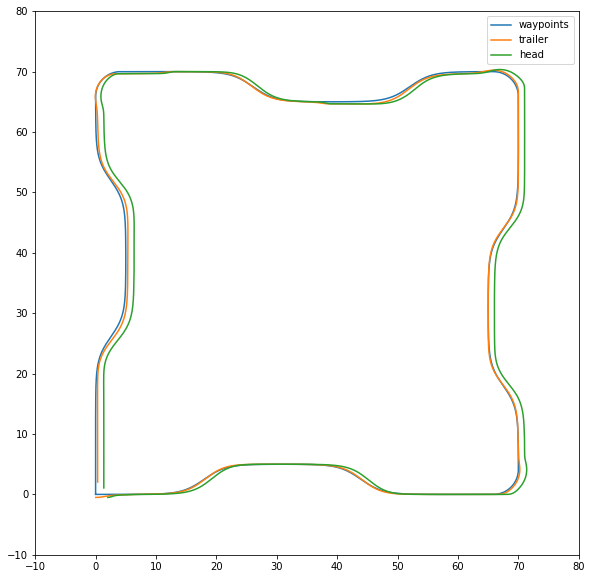

In [10]:
plt.figure(figsize=(15,10))
plt.axis('square')
plt.xlim([-10,segment_length+10])
plt.ylim([-10,segment_length+10])
plt.plot(waypoints[:,0], waypoints[:,1], label="waypoints")
plt.plot(log["x_trailer"], log["y_trailer"], label="trailer")
plt.plot(log["x_head"], log["y_head"], label="head")
plt.legend()

wp 27470
idx 27272


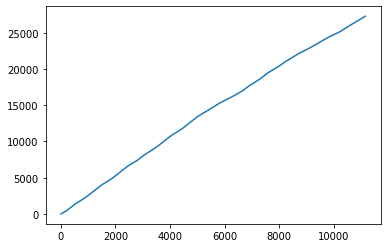

In [11]:
print("wp", len(waypoints))
print("idx", np.max(log["idx_closest"]))
plt.plot(log["idx_closest"])

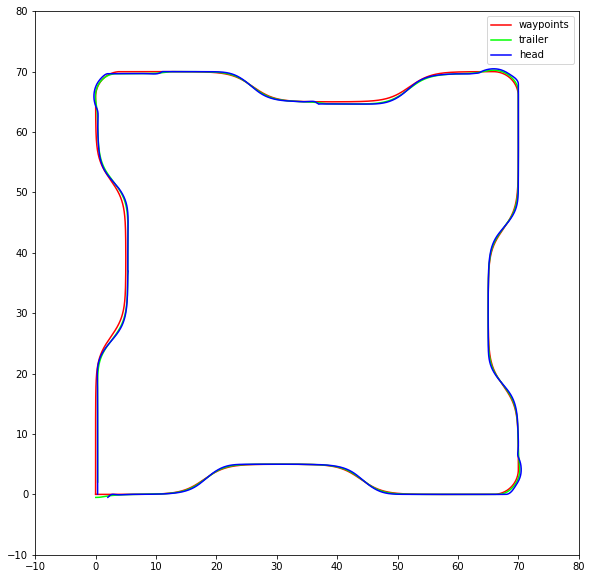

In [12]:
# EXP: Redraw x,y_head, with assumption: trailer mass >>> head mass
log["redrawn_x_head"] = log["x_trailer"] + truck_a.l_trailer*np.cos(log["theta_trailer"]) + truck_a.l_head*np.cos(log["theta_head"])
log["redrawn_y_head"] = log["y_trailer"] + truck_a.l_trailer*np.sin(log["theta_trailer"]) + truck_a.l_head*np.sin(log["theta_head"])

plt.figure(figsize=(15,10))
plt.axis('square')
plt.xlim([-10,segment_length+10])
plt.ylim([-10,segment_length+10])
plt.plot(waypoints[:,0], waypoints[:,1], label="waypoints", c='red')
plt.plot(log["x_trailer"], log["y_trailer"], label="trailer", c='lime')
plt.plot(log["redrawn_x_head"], log["redrawn_y_head"], label="head", c='blue')
plt.legend()

In [13]:
# # EXP: Redraw x,y_trailer, with assumption: head mass >>> trailer mass
# log["redrawn_x_trailer"] = log["x_head"] - truck_a.l_trailer*np.cos(log["theta_trailer"]) - truck_a.l_head*np.cos(log["theta_head"])
# log["redrawn_y_trailer"] = log["y_head"] - truck_a.l_trailer*np.sin(log["theta_trailer"]) - truck_a.l_head*np.sin(log["theta_head"])
# plt.plot(waypoints[:,0], waypoints[:,1], label="waypoints")
# plt.plot(log["redrawn_x_trailer"], log["redrawn_y_trailer"], label="trailer")
# plt.plot(log["x_head"], log["y_head"], label="head")
# plt.legend()
# plt.axis('equal')

## Visualization

### Visual object definition

In [14]:
class TruckTrailerVisual:
  def __init__(self,
               l_trailer, trailer_box_length, trailer_box_width, trailer_joint_length,
               l_head, head_box_length, head_box_width,
               wheel_width=0.3, wheel_diameter=0.7):
    self.l_trailer = l_trailer
    self.trailer_box_width = trailer_box_width
    self.trailer_box_length = trailer_box_length
    self.trailer_joint_length = trailer_joint_length
    self.wheel_width = wheel_width
    self.wheel_diameter = wheel_diameter

    self.l_head = l_head
    self.head_box_width = head_box_width
    self.head_box_length = head_box_length

    self.d_steer = 0
    self.pose_trailer = [0, 0, 0]
    self.pose_head = [self.l_trailer+self.l_head, 0, 0]

    self.update(self.pose_trailer, self.pose_head, self.d_steer)


  def update(self, pose_trailer, pose_head, d_steer):
    self.d_steer = d_steer
    self.pose_trailer = pose_trailer
    self.pose_head = pose_head

    self.data = {}
    trailer_box_margin2axle = self.trailer_box_length + self.trailer_joint_length - self.l_trailer
    # print("trailer_box_margin2axle", trailer_box_margin2axle)
    self.data["trailer_box"] = createMiddleLeftRectangle([-trailer_box_margin2axle,0,0], 
                                                              self.trailer_box_length, self.trailer_box_width)
    trailer_wheel_lateral_pos = self.trailer_box_width/2+self.wheel_width/2
    # print("trailer_wheel_lateral_pos", trailer_wheel_lateral_pos)
    self.data["trailer_wheel_rear_left"] = createCenterRectangle([0, trailer_wheel_lateral_pos, 0],
                                                                 self.wheel_diameter, self.wheel_width)
    self.data["trailer_wheel_rear_right"] = createCenterRectangle([0, -trailer_wheel_lateral_pos, 0],
                                                                 self.wheel_diameter, self.wheel_width)
    trailer_wheel_front_dist = self.trailer_box_length - 2*trailer_box_margin2axle
    # print("trailer_wheel_front_dist", trailer_wheel_front_dist)
    self.data["trailer_wheel_front_left"] = createCenterRectangle([trailer_wheel_front_dist, trailer_wheel_lateral_pos, 0],
                                                                  self.wheel_diameter, self.wheel_width)
    self.data["trailer_wheel_front_right"] = createCenterRectangle([trailer_wheel_front_dist,-trailer_wheel_lateral_pos, 0],
                                                                 self.wheel_diameter, self.wheel_width)
    self.data["trailer_joint"] = np.array([[self.l_trailer, 0],
                                      [self.l_trailer-self.trailer_joint_length, self.trailer_box_width/2],
                                      [self.l_trailer-self.trailer_joint_length, -self.trailer_box_width/2]])

    self.data["head_box"] = createMiddleLeftRectangle([-(self.l_head+(self.head_box_length-self.l_head)/2), 0, 0], 
                                                           self.head_box_length, self.head_box_width)
    head_wheel_lateral_pos = self.head_box_width/2 + self.wheel_width/2
    self.data["head_wheel_front_left"] = transformFrame(createCenterRectangle([0,0,0], self.wheel_diameter, self.wheel_width),
                                                    [0, head_wheel_lateral_pos, d_steer])
    self.data["head_wheel_front_right"] = transformFrame(createCenterRectangle([0,0,0], self.wheel_diameter, self.wheel_width),
                                                     [0, -head_wheel_lateral_pos, d_steer])
    self.data["head_wheel_rear_right"] = transformFrame(createCenterRectangle([0,0,0], self.wheel_diameter, self.wheel_width),
                                                    [-self.l_head, -head_wheel_lateral_pos, 0])
    self.data["head_wheel_rear_left"] = transformFrame(createCenterRectangle([0,0,0], self.wheel_diameter, self.wheel_width),
                                                   [-self.l_head, head_wheel_lateral_pos, 0])
    
    for key in self.data:
      if "trailer" in key:
        self.data[key] = transformFrame(self.data[key], pose_trailer)
      if "head" in key:
        self.data[key] = transformFrame(self.data[key], pose_head)

  def display(self, zorder):
    lw = 1
    plt.fill(self.data["head_box"][:,0], self.data["head_box"][:,1], 
            facecolor='none', edgecolor='black', linewidth=lw, zorder=zorder)
    plt.fill(self.data["head_wheel_front_left"][:,0], self.data["head_wheel_front_left"][:,1], 
            facecolor='gray', edgecolor='black', linewidth=lw, zorder=zorder)
    plt.fill(self.data["head_wheel_front_right"][:,0], self.data["head_wheel_front_right"][:,1], 
            facecolor='gray', edgecolor='black', linewidth=lw, zorder=zorder)
    plt.fill(self.data["head_wheel_rear_left"][:,0], self.data["head_wheel_rear_left"][:,1], 
            facecolor='gray', edgecolor='black', linewidth=lw, zorder=zorder)
    plt.fill(self.data["head_wheel_rear_right"][:,0], self.data["head_wheel_rear_right"][:,1], 
            facecolor='gray', edgecolor='black', linewidth=lw, zorder=zorder)
    plt.fill(self.data["trailer_box"][:,0], self.data["trailer_box"][:,1],
            facecolor='none', edgecolor='black', linewidth=lw, zorder=zorder)
    plt.fill(self.data["trailer_joint"][:,0], self.data["trailer_joint"][:,1], 
            facecolor='none', edgecolor='black', linewidth=lw, zorder=zorder)
    plt.fill(self.data["trailer_wheel_rear_left"][:,0], self.data["trailer_wheel_rear_left"][:,1], 
            facecolor='gray', edgecolor='black', linewidth=lw, zorder=zorder)
    plt.fill(self.data["trailer_wheel_rear_right"][:,0], self.data["trailer_wheel_rear_right"][:,1], 
            facecolor='gray', edgecolor='black', linewidth=lw, zorder=zorder)
    plt.fill(self.data["trailer_wheel_front_left"][:,0], self.data["trailer_wheel_front_left"][:,1],
            facecolor='none', edgecolor='black', linewidth=lw, zorder=zorder)
    plt.fill(self.data["trailer_wheel_front_right"][:,0], self.data["trailer_wheel_front_right"][:,1], 
            facecolor='none', edgecolor='black', linewidth=lw, zorder=zorder)
    # plt.fill(self.data["trailer_ref"][:,0], self.data["trailer_ref"][:,1], 
    #         facecolor='gray', edgecolor='black', linewidth=3)

def createCenterRectangle(ref_pose, width, height):
  return np.array([[ref_pose[0]-width/2, ref_pose[1]-height/2],
                  [ref_pose[0]-width/2, ref_pose[1]+height/2],
                  [ref_pose[0]+width/2, ref_pose[1]+height/2],
                  [ref_pose[0]+width/2, ref_pose[1]-height/2]])
  
def createBottomLeftRectangle(ref_pose, width, height):
  buf = createCenterRectangle([0,0,0], width, height)
  buf = transformFrame(buf, [width/2, height/2, 0])
  buf = transformFrame(buf, ref_pose)
  return buf

def createMiddleLeftRectangle(ref_pose, width, height):
  buf = createCenterRectangle([0,0,0], width, height)
  buf = transformFrame(buf, [width/2, 0, 0])
  buf = transformFrame(buf, ref_pose)
  return buf

def transformFrame(point_array, target_frame):
  buf = np.copy(point_array)
  #rotation
  buf[:,0] = np.cos(target_frame[2])*point_array[:,0] - np.sin(target_frame[2])*point_array[:,1]
  buf[:,1] = np.sin(target_frame[2])*point_array[:,0] + np.cos(target_frame[2])*point_array[:,1]
  #translation
  buf[:,0] = buf[:,0] + target_frame[0]
  buf[:,1] = buf[:,1] + target_frame[1]

  return buf

# # Dummy Object Test
# print(truck_a.l_trailer, truck_a.l_head)
# test = TruckTrailerVisual(l_trailer=truck_a.l_trailer,
#                                  trailer_box_length=1, trailer_box_width=1, trailer_joint_length=0.2,
#                                  l_head=truck_a.l_head, head_box_length=1, head_box_width=1,
#                                  wheel_width=0.2, wheel_diameter=0.4)
# # test = TruckTrailerVisual(5, 5, 2, 0.5,
# #                                  1, 2, 2)
# # test.update([0,0,np.pi/4], [5,5,0], -np.pi/6)
# test.update([1,1,np.pi/4], [8,8,0], -np.pi/6)
# test.display(10)
# plt.scatter(test.pose_head[0], test.pose_head[1], label="xy_head")
# plt.scatter(test.pose_trailer[0], test.pose_trailer[1], label="xy_trailer")
# plt.axis('equal')
# plt.legend()

In [15]:
obstacle_width = 2  # m
obstacle_height = line_distance
unsafezone_width = 1  # m
obstacle_visual_zorder = 5

obstacle_1_pose = [straight_path_length+sensor_detect_distance, 0, 0]
obstacle_2_pose = [straight_path_length+(sensor_detect_distance-k_sigmoid_2)*2+sensor_detect_distance, line_distance, 0]
obstacle_3_pose = [segment_length, straight_path_length+sensor_detect_distance, np.pi/2]
obstacle_4_pose = [segment_length-line_distance, straight_path_length+(sensor_detect_distance-k_sigmoid_2)*2+sensor_detect_distance, np.pi/2]
obstacle_5_pose = [segment_length-(straight_path_length+sensor_detect_distance), segment_length, np.pi]
obstacle_6_pose = [segment_length-(straight_path_length+(sensor_detect_distance-k_sigmoid_2)*2+sensor_detect_distance), segment_length-line_distance, np.pi]
obstacle_7_pose = [0, segment_length-(straight_path_length+sensor_detect_distance), -np.pi/2]
obstacle_8_pose = [line_distance, segment_length-(straight_path_length+(sensor_detect_distance-k_sigmoid_2)*2+sensor_detect_distance), -np.pi/2]

obstacle_1_visual = createMiddleLeftRectangle(obstacle_1_pose, obstacle_width, obstacle_height)
obstacle_2_visual = createMiddleLeftRectangle(obstacle_2_pose, obstacle_width, obstacle_height)
obstacle_3_visual = createMiddleLeftRectangle(obstacle_3_pose, obstacle_width, obstacle_height)
obstacle_4_visual = createMiddleLeftRectangle(obstacle_4_pose, obstacle_width, obstacle_height)
obstacle_5_visual = createMiddleLeftRectangle(obstacle_5_pose, obstacle_width, obstacle_height)
obstacle_6_visual = createMiddleLeftRectangle(obstacle_6_pose, obstacle_width, obstacle_height)
obstacle_7_visual = createMiddleLeftRectangle(obstacle_7_pose, obstacle_width, obstacle_height)
obstacle_8_visual = createMiddleLeftRectangle(obstacle_8_pose, obstacle_width, obstacle_height)

# unsafezone_1_visual = createBottomLeftRectangle([obstacle_distance-unsafezone_width, 0, 0],
#                                                  obstacle_width+unsafezone_width, obstacle_height/2+unsafezone_width)

# # test plot
# plt.fill(unsafezone_1_visual[:,0], unsafezone_1_visual[:,1], label="unsafe zone",
#          facecolor='#ccc', linewidth=0, zorder=obstacle_visual_zorder-1)
# plt.fill(obstacle_1_visual[:,0], obstacle_1_visual[:,1], label="obstacle",
#          facecolor='#666', linewidth=0, zorder=obstacle_visual_zorder)
# plt.legend()
# plt.axis('equal')

### Trajectory Plot Print

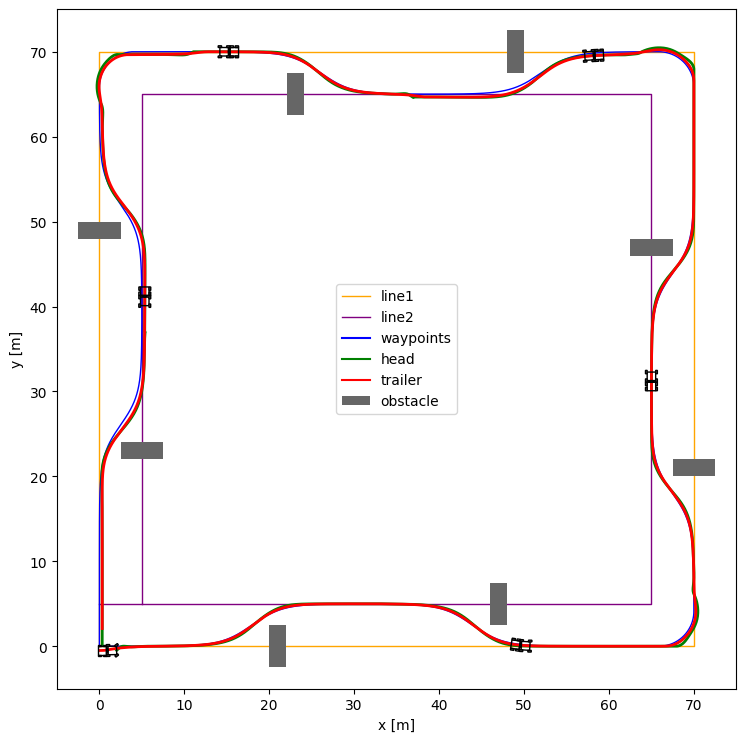

In [16]:

from IPython.display import Image

filename = 'trajectory_animation_print'

plot_margin = 5
plot_lim = [[np.min(waypoints[:,0])-plot_margin, np.max(waypoints[:,0])+plot_margin],
            [np.min(waypoints[:,1])-plot_margin, np.max(waypoints[:,1])+plot_margin]]
truck_a_vis = TruckTrailerVisual(l_trailer=truck_a.l_trailer,
                                 trailer_box_length=truck_a.l_trailer, trailer_box_width=1, trailer_joint_length=0.2,
                                 l_head=truck_a.l_head, head_box_length=truck_a.l_head, head_box_width=1,
                                 wheel_width=0.2, wheel_diameter=0.4)

i = len(log["x_head"])-2
fig = plt.figure(figsize=(9,9), dpi=100)

# Path visual
plt.plot(waypoints[:,0], waypoints[:,1],
            # label='waypoints',
            # s=0.2,
            lw=1,
            c='blue', zorder=10)
plt.plot(line1[:,0], line1[:,1], label="line1", zorder=3, c='orange', lw=1)
plt.plot(line2[:,0], line2[:,1], label="line2", zorder=3, c='purple', lw=1)
# plt.scatter(log["x_head"][:i], log["y_head"][:i], s=0.5, c='red', label='head',
#             zorder=12)
plt.plot(log["redrawn_x_head"][:i], log["redrawn_y_head"][:i], 
            # label="head",
            # s=0.5,
            lw=2,
            c='green', zorder=11)
plt.plot(log["x_trailer"][:i], log["y_trailer"][:i], 
            # label='trailer',
            # s=0.5,
            lw=2,
            c='red', zorder=12)
## legend purpose
plt.plot([], c='blue', label="waypoints")
plt.plot([],c='green', label="head")
plt.plot([], c='red', label="trailer")


# Truck visual
truck_snapshot_num = 6
for j in range(truck_snapshot_num):
  i = j * int(len(log["x_head"])/truck_snapshot_num)
  # truck_a_vis.update([log["x_trailer"][i], log["y_trailer"][i], log["theta_trailer"][i]],
  #                     [log["x_head"][i], log["y_head"][i], log["theta_head"][i]],
  #                     log["d_steer"][i])
  ## EXP: use redrawn x,y_head
  truck_a_vis.update([log["x_trailer"][i], log["y_trailer"][i], log["theta_trailer"][i]],
                      [log["redrawn_x_head"][i], log["redrawn_y_head"][i], log["theta_head"][i]],
                      log["d_steer"][i])
  ## EXP: use redrawn x,y_trailer
  # truck_a_vis.update([log["redrawn_x_trailer"][i], log["redrawn_y_trailer"][i], log["theta_trailer"][i]],
  #                     [log["x_head"][i], log["y_head"][i], log["theta_head"][i]],
  #                     log["d_steer"][i])
  truck_a_vis.display(zorder=13)

# Obstacle and unsafe zone visual
# plt.fill(unsafezone_1_visual[:,0], unsafezone_1_visual[:,1], label="unsafe zone",
#           facecolor='#ccc', linewidth=0, zorder=obstacle_visual_zorder-1)
plt.fill(obstacle_1_visual[:,0], obstacle_1_visual[:,1], label="obstacle",
          facecolor='#666', linewidth=0, zorder=obstacle_visual_zorder)
plt.fill(obstacle_2_visual[:,0], obstacle_2_visual[:,1],
          facecolor='#666', linewidth=0, zorder=obstacle_visual_zorder)
plt.fill(obstacle_3_visual[:,0], obstacle_3_visual[:,1],
          facecolor='#666', linewidth=0, zorder=obstacle_visual_zorder)
plt.fill(obstacle_4_visual[:,0], obstacle_4_visual[:,1],
          facecolor='#666', linewidth=0, zorder=obstacle_visual_zorder)
plt.fill(obstacle_5_visual[:,0], obstacle_5_visual[:,1],
          facecolor='#666', linewidth=0, zorder=obstacle_visual_zorder)
plt.fill(obstacle_6_visual[:,0], obstacle_6_visual[:,1],
          facecolor='#666', linewidth=0, zorder=obstacle_visual_zorder)
plt.fill(obstacle_7_visual[:,0], obstacle_7_visual[:,1],
          facecolor='#666', linewidth=0, zorder=obstacle_visual_zorder)
plt.fill(obstacle_8_visual[:,0], obstacle_8_visual[:,1],
          facecolor='#666', linewidth=0, zorder=obstacle_visual_zorder)

# Overlay info
# overlay_txt = "time: " + "{:.2f}".format(i*0.05) + " s"
# overlay_txt += "\n" + r"$v_{head}$: " + "{:.2f}".format(log["v_head"][i]) + " m/s"
# overlay_txt += "\n"+ r"$d_{steer}$: " + "{:.2f}".format(log["d_steer"][i]) + " rad"
# overlay_box = dict(boxstyle='square', ec='#ddd', fc='#fff', alpha=0.8)
# plt.text(0.02, 0.98, overlay_txt,
#           horizontalalignment='left',
#           verticalalignment='top',
#           transform = plt.gca().transAxes, bbox=overlay_box)

plt.axis('square')
plt.legend()
# plt.grid(zorder=1)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.xlim(plot_lim[0])
plt.ylim(plot_lim[1])
plt.savefig("trajectory_plot_print.png")

### Trajectory Plot Animation

In [17]:

from IPython.display import Image

filename = 'trajectory_plot_animation'
buf_folder = filename+'_steps'
!mkdir $buf_folder
figsize=(9,9)
dpi=100
framecounter=0

plot_lim = [[np.min(waypoints[:,0])-5, np.max(waypoints[:,0])+5],
            [np.min(waypoints[:,1])-5, np.max(waypoints[:,1])+15]]
truck_a_vis = TruckTrailerVisual(l_trailer=truck_a.l_trailer,
                                 trailer_box_length=truck_a.l_trailer, trailer_box_width=1, trailer_joint_length=0.2,
                                 l_head=truck_a.l_head, head_box_length=truck_a.l_head, head_box_width=1,
                                 wheel_width=0.2, wheel_diameter=0.4)

print("Frame rendering started...")
for i in range(len(log["x_head"])):
  if i%10 == 0:
    # i = len(log["x_head"])-2
    fig = plt.figure(figsize=figsize, dpi=dpi)

    # Path visual
    plt.plot(waypoints[:,0], waypoints[:,1],
                # label='waypoints',
                # s=0.2,
                lw=1,
                c='blue', zorder=10)
    plt.plot(line1[:,0], line1[:,1], label="line1", zorder=3, c='orange', lw=1)
    plt.plot(line2[:,0], line2[:,1], label="line2", zorder=3, c='purple', lw=1)
    # plt.scatter(log["x_head"][:i], log["y_head"][:i], s=0.5, c='red', label='head',
    #             zorder=12)
    plt.plot(log["redrawn_x_head"][:i], log["redrawn_y_head"][:i], 
                # label="head",
                # s=0.5,
                lw=2,
                c='green', zorder=11)
    plt.plot(log["x_trailer"][:i], log["y_trailer"][:i], 
                # label='trailer',
                # s=0.5,
                lw=2,
                c='red', zorder=12)
    ## legend purpose
    plt.plot([], c='blue', label="waypoints")
    plt.plot([],c='green', label="head")
    plt.plot([], c='red', label="trailer")

    # Truck visual
    # truck_a_vis.update([log["x_trailer"][i], log["y_trailer"][i], log["theta_trailer"][i]],
    #                     [log["x_head"][i], log["y_head"][i], log["theta_head"][i]],
    #                     log["d_steer"][i])
    ## EXP: use redrawn x,y_head
    truck_a_vis.update([log["x_trailer"][i], log["y_trailer"][i], log["theta_trailer"][i]],
                        [log["redrawn_x_head"][i], log["redrawn_y_head"][i], log["theta_head"][i]],
                        log["d_steer"][i])
    ## EXP: use redrawn x,y_trailer
    # truck_a_vis.update([log["redrawn_x_trailer"][i], log["redrawn_y_trailer"][i], log["theta_trailer"][i]],
    #                     [log["x_head"][i], log["y_head"][i], log["theta_head"][i]],
    #                     log["d_steer"][i])

    truck_a_vis.display(zorder=13)

    # Obstacle and unsafe zone visual
    # plt.fill(unsafezone_1_visual[:,0], unsafezone_1_visual[:,1], label="unsafe zone",
    #           facecolor='#ccc', linewidth=0, zorder=obstacle_visual_zorder-1)
    plt.fill(obstacle_1_visual[:,0], obstacle_1_visual[:,1], label="obstacle",
              facecolor='#666', linewidth=0, zorder=obstacle_visual_zorder)
    plt.fill(obstacle_2_visual[:,0], obstacle_2_visual[:,1],
              facecolor='#666', linewidth=0, zorder=obstacle_visual_zorder)
    plt.fill(obstacle_3_visual[:,0], obstacle_3_visual[:,1],
              facecolor='#666', linewidth=0, zorder=obstacle_visual_zorder)
    plt.fill(obstacle_4_visual[:,0], obstacle_4_visual[:,1],
              facecolor='#666', linewidth=0, zorder=obstacle_visual_zorder)
    plt.fill(obstacle_5_visual[:,0], obstacle_5_visual[:,1],
              facecolor='#666', linewidth=0, zorder=obstacle_visual_zorder)
    plt.fill(obstacle_6_visual[:,0], obstacle_6_visual[:,1],
              facecolor='#666', linewidth=0, zorder=obstacle_visual_zorder)
    plt.fill(obstacle_7_visual[:,0], obstacle_7_visual[:,1],
              facecolor='#666', linewidth=0, zorder=obstacle_visual_zorder)
    plt.fill(obstacle_8_visual[:,0], obstacle_8_visual[:,1],
              facecolor='#666', linewidth=0, zorder=obstacle_visual_zorder)

    # Overlay info
    overlay_txt = "time: " + "{:.2f}".format(i*0.05) + " s"
    overlay_txt += "\n" + r"$v_{head}$: " + "{:.2f}".format(log["v_head"][i]) + " m/s"
    overlay_txt += "\n"+ r"$d_{steer}$: " + "{:.2f}".format(log["d_steer"][i]) + " rad"
    overlay_box = dict(boxstyle='square', ec='#ddd', fc='#fff', alpha=0.8)
    plt.text(0.02, 0.98, overlay_txt,
              horizontalalignment='left',
              verticalalignment='top',
              transform = plt.gca().transAxes, bbox=overlay_box)

    plt.axis('square')
    plt.legend()
    # plt.grid(zorder=1)
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.xlim(plot_lim[0])
    plt.ylim(plot_lim[1])
    framecounter = framecounter + 1
    framename=buf_folder+'/'+'frame'+str(framecounter).zfill(10)+'.png'
    plt.savefig(framename)
    plt.close(fig)
print("Frame rendering finished.")

Frame rendering started...
Frame rendering finished.


In [18]:
# OLD: using imagemagick

# !apt-get install imagemagick -qq

# imagemagick_frames = buf_folder + '/step*.png'
# imagemagick_file_gif = filename + '.gif'
# imagemagick_file_mp4 = filename + '.mp4'
# # !convert -delay 10 $imagemagick_frames $imagemagick_file_mp4 #TODO: 
# print("Rendering gif from frame started...")
# !convert -delay 10 $imagemagick_frames $imagemagick_file_gif
# print("Rendering gif from frame finished.")
# !rm -r $buf_folder
# Image(open(imagemagick_file_gif,'rb').read())

In [19]:
# NEW: using ffmpeg
# ref: https://hamelot.io/visualization/using-ffmpeg-to-convert-a-set-of-images-into-a-video/

!apt install ffmpeg
ffmpeg_filename=filename+"_ffmpeg.mp4"
fps=30
frame_size=str(figsize[0]*dpi) + 'x' + str(figsize[1]*dpi)
print("frame_size",frame_size)
frame_name=buf_folder+"/"+"frame%010d.png"
!ffmpeg -r $fps -f image2 -s $frame_size -i $frame_name -vcodec libx264 -crf 25  -pix_fmt yuv420p -y $ffmpeg_filename

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
frame_size 900x900
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --ena

In [20]:
!rm -r $buf_folder

In [21]:
# Show result in colab
# ref: https://stackoverflow.com/questions/57377185/how-play-mp4-video-in-google-colab

from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = ffmpeg_filename

# Compressed video path
compressed_path = filename+"_ffmpeg_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 -y {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

### Time Series Plot

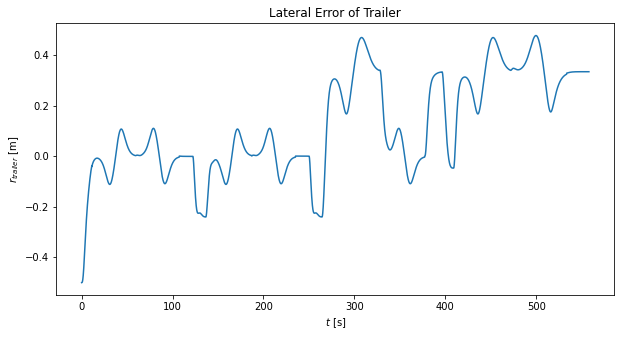

In [22]:
t = np.linspace(0, 0.05*(len(log["x_head"])-1), len(log["x_head"]))
buf_trailer = log["r_trailer_e"].copy()
for i in range(len(log["x_head"])-1):
  if np.abs(buf_trailer[i+1]-buf_trailer[i]) > 0.2:
    buf_trailer[i+1] = buf_trailer[i]

plt.figure(figsize=(10,5))
# plt.plot(t, log["r_trailer_e"], label="r_trailer_e")
plt.plot(t, buf_trailer, label="r_trailer_e")
plt.ylabel(r"$r_{trailer}$ [m]")
plt.xlabel(r"$t$ [s]")
plt.title("Lateral Error of Trailer")
# plt.grid()
# plt.legend()
plt.savefig("timeseries_lateral_error_trailer.png")

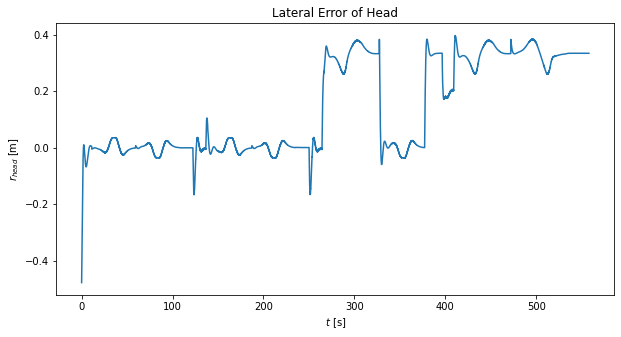

In [23]:
t = np.linspace(0, 0.05*(len(log["x_head"])-1), len(log["x_head"]))
log["r_head_e"] = []
for i in range(len(log["idx_closest"])):
  # x_ref, y_ref = log["x_head"][i], log["y_head"][i]
  x_ref, y_ref = log["redrawn_x_head"][i], log["redrawn_y_head"][i]
  # if self.idx_closest == 0:
  #   self.idx_closest = 1
  x2 = waypoints[log["idx_closest"][i], 0]
  y2 = waypoints[log["idx_closest"][i], 1]
  x1 = waypoints[log["idx_closest"][i] - 1, 0]
  y1 = waypoints[log["idx_closest"][i] - 1, 1]
  dy = y2 - y1
  dx = x2 - x1
  c = dx*y1 - dy*x1

  r_head_e = -1 * (dy*x_ref + c - dx*y_ref) \
                      / (np.sqrt(dx**2 + dy**2) + 10**(-32))
  log["r_head_e"].append(r_head_e)

for i in range(len(log["x_head"])-1):
  if np.abs(log["r_head_e"][i+1]-log["r_head_e"][i]) > 0.2:
    log["r_head_e"][i+1] = log["r_head_e"][i]

plt.figure(figsize=(10,5))
plt.plot(t, log["r_head_e"], label="r_head_e")
plt.ylabel(r"$r_{head}$ [m]")
plt.xlabel(r"$t$ [s]")
plt.title("Lateral Error of Head")
# plt.grid()
# plt.legend()
plt.savefig("timeseries_lateral_error_head.png")

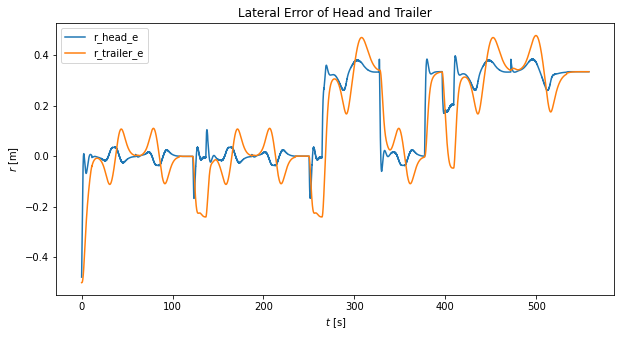

In [24]:
plt.figure(figsize=(10,5))
plt.plot(t, log["r_head_e"], label="r_head_e")
plt.plot(t, buf_trailer, label="r_trailer_e")
plt.ylabel(r"$r$ [m]")
plt.xlabel(r"$t$ [s]")
plt.title("Lateral Error of Head and Trailer")
# plt.grid()
plt.legend()
plt.savefig("timeseries_lateral_error_head_and_trailer.png")

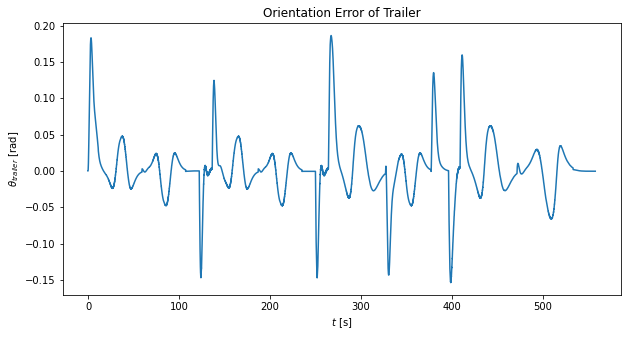

In [25]:
plt.figure(figsize=(10,5))
t = np.linspace(0, 0.05*(len(log["x_head"])-1), len(log["x_head"]))
plt.plot(t, log["theta_trailer_e"], label="theta_trailer_e")
# plt.grid()
plt.ylabel(r"$\theta_{trailer}$ [rad]")
plt.xlabel(r"$t$ [s]")
plt.title("Orientation Error of Trailer")
# plt.legend()
plt.savefig("timeseries_orientation_error_trailer.png")

In [26]:
# plt.figure(figsize=(10,5))
# t = np.linspace(0, 0.05*(len(log["x_head"])-1), len(log["x_head"]))
# plt.plot(t, log["theta_head_e"], label="theta_head_e")
# plt.grid()
# plt.ylabel(r"$\theta_{head}$ [rad]")
# plt.xlabel(r"$t$ [s]")
# plt.title("Orientation Error of Head")
# # plt.legend()

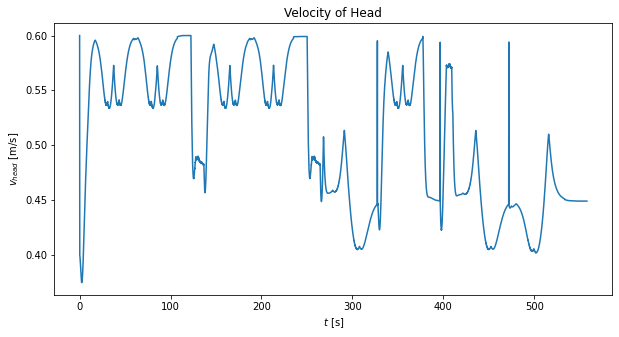

In [27]:
plt.figure(figsize=(10,5))
t = np.linspace(0, 0.05*(len(log["x_head"])-1), len(log["x_head"]))
plt.plot(t, log["v_head"], label="v_head")
# plt.grid()
plt.ylabel(r"$v_{head}$ [m/s]")
plt.xlabel(r"$t$ [s]")
plt.title("Velocity of Head")
# plt.legend()
plt.savefig("timeseries_velocity_head.png")

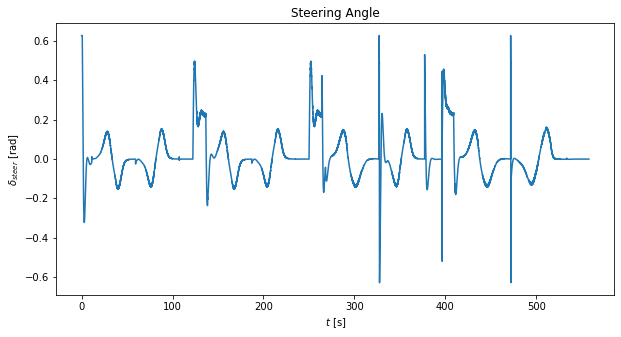

In [28]:
plt.figure(figsize=(10,5))
t = np.linspace(0, 0.05*(len(log["x_head"])-1), len(log["x_head"]))
plt.plot(t, log["d_steer"], label="d_steer")
# plt.grid()
plt.ylabel(r"$\delta_{steer}$ [rad]")
plt.xlabel(r"$t$ [s]")
plt.title("Steering Angle")
# plt.legend()
plt.savefig("timeseries_steering_angle.png")

### Performance Index

In [29]:
def _iae(e):
    return np.sum(np.abs(e))

def _ise(e):
    return np.sum(np.square(e))

def _itae(t, e):
    itae = 0
    for i in range(len(e)):
        itae += (t[i] * np.abs(e[i]))
    return itae

def _itse(t, e):
    itse = 0
    for i in range(len(e)):
        itse += (t[i] * np.square(e[i]))
    return itse

def _mae(e):
    return np.mean(np.abs(e))

def _mse(e):
    return np.mean(np.square(e))

def _rmse(e):
    return np.sqrt(np.mean(np.square(e)))

In [30]:
t = np.linspace(0, 0.05*(len(log["r_trailer_e"])-1), len(log["r_trailer_e"]))
performance_index = {}
performance_index["r_trailer_e_mae"] = _mae(log["r_trailer_e"])
performance_index["r_trailer_e_mse"] = _mse(log["r_trailer_e"])
performance_index["r_trailer_e_rmse"] = _rmse(log["r_trailer_e"])
performance_index["r_trailer_e_iae"] = _iae(log["r_trailer_e"])
performance_index["r_trailer_e_ise"] = _ise(log["r_trailer_e"])
performance_index["r_trailer_e_itae"] = _itae(t, log["r_trailer_e"])
performance_index["r_trailer_e_itse"] = _itse(t, log["r_trailer_e"])

for key in performance_index:
  print(str(key)+':', performance_index[key])

r_trailer_e_mae: 0.17338169187347527
r_trailer_e_mse: 0.05244786473704608
r_trailer_e_rmse: 0.22901498801835238
r_trailer_e_iae: 1934.9396813079838
r_trailer_e_ise: 585.3181704654343
r_trailer_e_itae: 713249.1624591951
r_trailer_e_itse: 231827.1474992068


In [31]:
t = np.linspace(0, 0.05*(len(log["theta_trailer_e"])-1), len(log["theta_trailer_e"]))
performance_index = {}
performance_index["theta_trailer_e_mae"] = _mae(log["theta_trailer_e"])
performance_index["theta_trailer_e_mse"] = _mse(log["theta_trailer_e"])
performance_index["theta_trailer_e_rmse"] = _rmse(log["theta_trailer_e"])
performance_index["theta_trailer_e_iae"] = _iae(log["theta_trailer_e"])
performance_index["theta_trailer_e_ise"] = _ise(log["theta_trailer_e"])
performance_index["theta_trailer_e_itae"] = _itae(t, log["theta_trailer_e"])
performance_index["theta_trailer_e_itse"] = _itse(t, log["theta_trailer_e"])

for key in performance_index:
  print(str(key)+':', performance_index[key])

theta_trailer_e_mae: 0.025803116735083967
theta_trailer_e_mse: 0.0017838497012711138
theta_trailer_e_rmse: 0.04223564491364035
theta_trailer_e_iae: 287.96278276353706
theta_trailer_e_ise: 19.90776266618563
theta_trailer_e_itae: 79669.48721522054
theta_trailer_e_itse: 5288.742339804789


In [32]:
mean_vh = np.mean(log["v_head"])
mean_d_steer = np.mean(log["d_steer"])

print("mean_vh:", mean_vh)
print("d_steer:", d_steer)

mean_vh: 0.5085916080406319
d_steer: -6.79638368311918e-08
